# Echelle spectrograph image processing notebook

The purpose of this notebook is to outline a basic workflow for the initial image processing required when dealing with data from a high-resolution echelle spectrograph. The code here was originally developed to work with testing and commissioning data from the new echelle spectrograph at the Macquarie University observatory, built and installed throughout 2020.

---
## Preliminary Steps

### About this code



Notebook Version: 2.1

Author: Jake Pember & Richard McDermid

Python 3.8.3

History:

*   v2.0: Scripts adapted and packaged for ASTR3010 lab. JP 12/2/21
*   v2.1: Added wavelength calibration.  RMcD 1/3/21

---

Package dependencies:
* `numpy` for numeric operations on arrays
* `matplotlib` to plot data for inspection
* `astropy.io` to enable FITS file handling
* `glob` for searching for directories and files by name
* `scipy.signal` for the handy `find_peaks` function
* `scipy.optimize` for the handy `curve_fit` function

---


### Imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from glob import glob
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

### Link to your google drive
This will allow you to access files on your google drive. It will open a new window - follow the instructions, and you will be given a code. Paste the code into the response box below, and your done. This has to be done everytime to open the notebook, but just takes a few seconds.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


###Custom Functions
Here we define some functions to load, calibrate, and stack the appropriate images taken through the spectrograph. While **you should not edit these**, have a look through them,  and see if you can follow what is going on. You need to run these cells, so that the subsequent steps can use these functions in the data reduction process.

In [ ]:
def load_fits_images(base_dir=".", keyword="[Ll]ight", recursive=False, debug_level=1):
    """
    A function to load a series of FITS images
    
    base_dir -- string, relative or absolute directory containing the files to be loaded.
    keyword -- string, a regex expression with a keyword to look for in the filenames.
    Filenames not matching the expression are ignored.
    recursive -- boolean, if True, files within subfolders are also searched.
    debug_level -- int or float, increase to display increasingly verbose debugging messages.

    returns a list of dictionaries, each with "HEADER" and "DATA" key, containing the FITS
    header and data array, respectively.
    """
    
    from glob import glob
    from astropy.io import fits
    
    mid_dir = "*/" * recursive
    if keyword is not None:
        dir_string = base_dir + "/" + mid_dir + "*" + keyword + "*.[Ff][Ii][Tt]*"
    else:
        dir_string = base_dir + "/" + mid_dir + "*.[Ff][Ii][Tt]*"
    if debug_level > 0:
        print(dir_string)
    
    filenames = glob(dir_string)
    if debug_level > 0:
        print(filenames)
    
    data = []
    for f in filenames:
        d = {}
        file = fits.open(f)
        
        d["HEADER"] = file[0].header
        d["DATA"] = file[0].data
        
        data.append(d)
        del d
        
        file.close()

    if debug_level > 0: print(f"{len(data)} frames loaded")
        
    return data

In [ ]:
def calibrate(light_frames, master_darks, master_bias=[], debug_level=1):
    """
    Helper function to calibrate FITS files from the SBIG 16803 detector on the spectrograph.
    The function finds the dark frame with closest exposure time and uses this for calibration.
    
    light_frames -- list of light frames to calibrate
    master_darks -- list of previously created master dark frames
    master_bias -- list of previously created bias frames, may be only one frame
    
    both of the lists of frames should be the direct output from the load_fits_images() function.
    This keeps FITS header and data arrays together.
    """
    
    calibrated = []

    for i, l in enumerate(light_frames):
        lightExpTime = l["HEADER"]["EXPTIME"]
        if debug_level > 0: print(f"Calibrating frame {i} with exposure time of {lightExpTime}")
            
        closestExpTime = np.inf
        for d in master_darks:
            darkExpTime = d["HEADER"]["EXPTIME"]
            if abs(lightExpTime - darkExpTime) == 0: # If we find an exact match, stop looking!
                closestExpTime = darkExpTime
                break
            elif abs(lightExpTime - darkExpTime) < abs(lightExpTime - closestExpTime):
                closestExpTime = darkExpTime
        if debug_level > 0: print(f"Closest dark exposure time: {closestExpTime}")

        dark_to_use = None
        if closestExpTime < np.inf:
            for d in master_darks:
                if d["HEADER"]["EXPTIME"] == closestExpTime:
                    dark_to_use = d
                    del d
                    break
        else: print(f"No dark frames found for calibration of {l}")
        if debug_level > 0: print("---")

        if closestExpTime != lightExpTime:

            if len(master_bias) >= 1:
                bias_to_use = master_bias[0]

                if debug_level > 0:
                    print("No exact matching dark frame found. Scaling the closest match.")

                dark = np.array(dark_to_use["DATA"], dtype="int32") - np.array(bias_to_use["DATA"], dtype="int32")
                light = np.array(l["DATA"], dtype="int32") - np.array(bias_to_use["DATA"], dtype="int32")
        
                if debug_level > 0: print("Calibrating...")
                l_calib = light - (dark * (lightExpTime / closestExpTime))

            else:
                if debug_level > 0:
                    print("No exact matching dark frame found. No bias frame found."\
                            +"Unable to scale dark frame. Using closest match.")
                light = np.array(l["DATA"], dtype="int32")
                l_calib = light - dark

        elif closestExpTime == lightExpTime:
            if debug_level > 0: print("Exact match found. Calibrating...")
            l_calib = np.array(l["DATA"], dtype="int32") - np.array(dark_to_use["DATA"], dtype="int32")
        
        calibrated.append({"HEADER": l["HEADER"], "DATA": l_calib})
        # Need to add dark frame information into the FITS header we output here

    return calibrated

In [ ]:
def stack_images(frames_to_stack, method="median"):
    """
    A simple function to take the median or mean of a stack of (pre-calibrated) frames.
    
    frames_to_stack -- list of dictionaries, a list of frames (FITS/dictionaries) with
    pixel array under the "DATA" key, as output from load_fits_images() or calibrate().
    method -- string, the numerical method by which to combine the frames. Options are
    "mean" and "median", self explanatory. Default "median".

    returns an array containing the resulting stack, without associated FITS header
    information.
    """
    
    imgdata = []
    
    for f in frames_to_stack:
        imgdata.append(f["DATA"])
    
    stack = np.zeros(imgdata[0].shape, dtype="int32")

    if method == "median":
        np.median(imgdata, axis=0, out=stack)
    
    if method == "mean":
        np.mean(imgdata, axis=0, out=stack)

    return stack

###Set Path Names
Now we input the root folder for light frames, the target name (the script will find images in the subfolder matching this), and the root folder for flat frames we want to load. These will depend on your chosen file structure.

***Your turn to code!***

Modify the paths and variables below to suit your directory structure and data set.

In [ ]:
# If you used a different directory name, change this line to reflect your own directory structure
dir = "/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/"
root_dir = dir

obs_date = "2022-03-21/" # Change this to match the date of the data you wish to analyse
target_name = "Sirius" # Change this to match your desired target name
sci_dir = target_name+"/"
flat_dir = "Flats/"
cal_dir = "../"+obs_date+"ThAr/"
darks_library = root_dir + "Darks Library - ASI1600MM-Pro/"

print(root_dir+obs_date+sci_dir)
print(darks_library)

/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/
/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/


In [ ]:
glob(root_dir+obs_date+sci_dir+"*")

['/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-09-13_001.fits',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-09-46_002.fits',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-10-19_003.fits',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-10-52_004.fits',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-11-25_005.fits',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-12-59_006.fits',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-13-32_007.fits',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-0

In [ ]:
glob(darks_library+"*")

['/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/masterDark_1.00s.fit',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/masterDark_5.00s.fit',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/masterDark_3.00s.fit',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/masterDark_1200.00s.fit',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/masterDark_600.00s.fit',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/masterDark_300.00s.fit',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/masterDark_120.00s.fit',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/Darks Library - ASI1600MM-Pro/masterDark_60.00s.fit',
 '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData

### Load data files into memory
Call the `load_fits_images` function to load the required frames. Check in the cell's output that there are the correct number of frames as you expect.

In [ ]:
lights = load_fits_images(base_dir=root_dir+obs_date+sci_dir)
print(f"{len(lights)} light/science frames loaded")
masterdarks = load_fits_images(base_dir=darks_library, keyword="masterDark")
print(f"{len(masterdarks)} dark frames loaded")
masterbias = load_fits_images(base_dir=darks_library, keyword="masterBias")
print(f"{len(masterbias)} bias frames loaded")

/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius//*[Ll]ight*.[Ff][Ii][Tt]*
['/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-09-13_001.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-09-46_002.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-10-19_003.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-10-52_004.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-11-25_005.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2022-03-21T20-12-59_006.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Sirius/Sirius_Light_30_secs_2

---
## Pre-processing and Extraction

###Pre-Process science frames
We want to pre-process the science frames we loaded, subtracting the appropriate dark frame from each one (which removes hot pixels) and detector bias  (which removes the bias pattern). We do this using the `calibrate()` function defined above.

In [ ]:
calibrated_lights = calibrate(lights, masterdarks, masterbias)

Calibrating frame 0 with exposure time of 30.0
Closest dark exposure time: 10.0
---
No exact matching dark frame found. Scaling the closest match.
Calibrating...
Calibrating frame 1 with exposure time of 30.0
Closest dark exposure time: 10.0
---
No exact matching dark frame found. Scaling the closest match.
Calibrating...
Calibrating frame 2 with exposure time of 30.0
Closest dark exposure time: 10.0
---
No exact matching dark frame found. Scaling the closest match.
Calibrating...
Calibrating frame 3 with exposure time of 30.0
Closest dark exposure time: 10.0
---
No exact matching dark frame found. Scaling the closest match.
Calibrating...
Calibrating frame 4 with exposure time of 30.0
Closest dark exposure time: 10.0
---
No exact matching dark frame found. Scaling the closest match.
Calibrating...
Calibrating frame 5 with exposure time of 30.0
Closest dark exposure time: 10.0
---
No exact matching dark frame found. Scaling the closest match.
Calibrating...
Calibrating frame 6 with exp

###Check outputs
We can now compare the original light frame with the calibrated one. You should see that calibration has removed many hot pixels (notice any bright single pixels in dark inter-order space in the original file that are removed in the calibrated frame). You may have to experiment with the `vmin` and `vmax` parameters to better see the background in your frames.

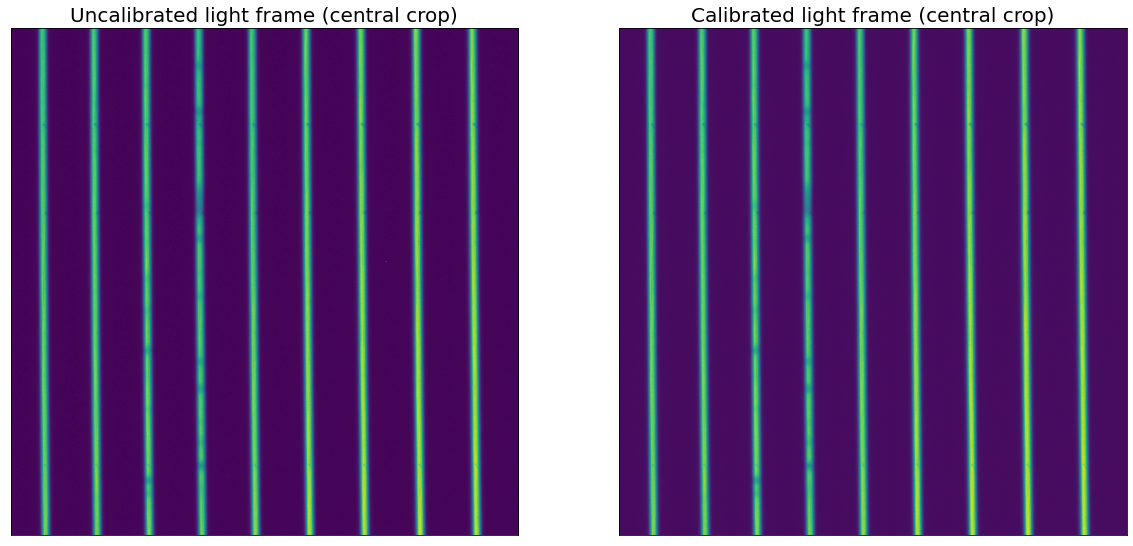

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 12))

axs[0].set_title("Uncalibrated light frame (central crop)", size=20)
axs[0].imshow(lights[0]["DATA"][1500:2500, 1500:2500] - np.median(lights[0]["DATA"]))
# Here we took the uncalibrated frame and naively subtract the bias level of ~300

axs[1].set_title("Calibrated light frame (central crop)", size=20)
axs[1].imshow(calibrated_lights[0]["DATA"][1500:2500, 1500:2500])

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

###Stack Multiple Exposures?
Optional: we can stack several frames of the same target and take the median or mean of each pixel value to reduce noise. Here our `lights` list contains only one frame, so it doesn't really do anything.

In [ ]:
stacked_light = stack_images(calibrated_lights)

###Clean Up
Lastly, we use the Python keyword `del` on the lists `lights` and `calibrated_lights` -- this deletes this variable (don't worry, nothing happens to the files we loaded), and frees up memory. These are big files and when loading several at a time, can quickly chew through available RAM.

In [ ]:
del lights
del calibrated_lights

###Check Outputs
Now we can have a look at the resulting stacked and calibrated light frame:

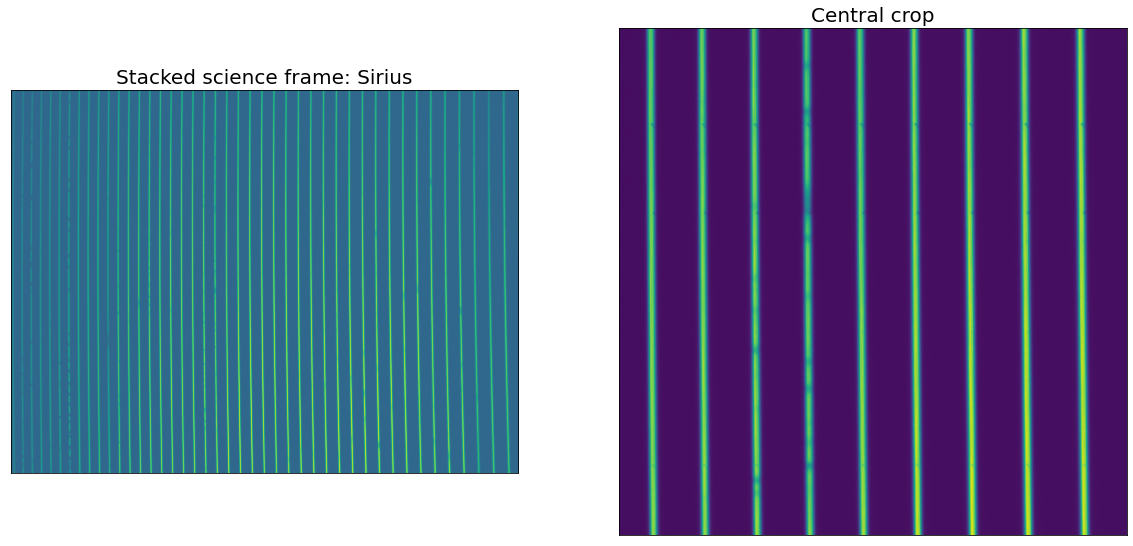

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

ax = axs[0]
ax.imshow(stacked_light)
ax.set_title(f"Stacked science frame: {target_name}", size=20)

ax = axs[1]
ax.imshow(stacked_light[1500:2500, 1500:2500])
ax.set_title("Central crop", size=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

###Process Calibrations
So, now that we have some science data from the spectrograph ready to go, we also need to load and process our calibration (flatfield calibration, wavelength calibration) frames from the same night.

**Wavelength calibration** frames show the spectrum of a thorium-argon hollow cathode lamp, which has many bright spetral features that we can look up in a spectral atlas.

**Flat frames** show a spectrum taken of a "white" (or "blackbody") continuum light source: something with no defined spectral features like the ones we (probably) see in the science frames. Illuminating the input fiber of the spectrograph with a halogen lamp or similar gives us what we need for flat frames.

We load the relevant wavelength calibration frames in the same way as above:

In [ ]:
cals = load_fits_images(base_dir=root_dir+obs_date+cal_dir)
print(f"{len(cals)} wavelength calibration frames loaded")
calibrated_cals = calibrate(cals, masterdarks, masterbias)
del cals
stacked_cal = stack_images(calibrated_cals)
del calibrated_cals

/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/../2022-03-21/ThAr//*[Ll]ight*.[Ff][Ii][Tt]*
['/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/../2022-03-21/ThAr/ThAr_Light_0.500_secs_2022-03-21T23-15-49_001.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/../2022-03-21/ThAr/ThAr_Light_0.500_secs_2022-03-21T23-15-52_002.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/../2022-03-21/ThAr/ThAr_Light_0.500_secs_2022-03-21T23-15-55_003.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/../2022-03-21/ThAr/ThAr_Light_0.500_secs_2022-03-21T23-15-58_004.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/../2022-03-21/ThAr/ThAr_Light_0.500_secs_2022-03-21T23-16-01_005.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/../2022-03-21/ThAr/ThAr_Light_0.500_secs_2022-03-21T23-16-05_006.fits', '/content/dr

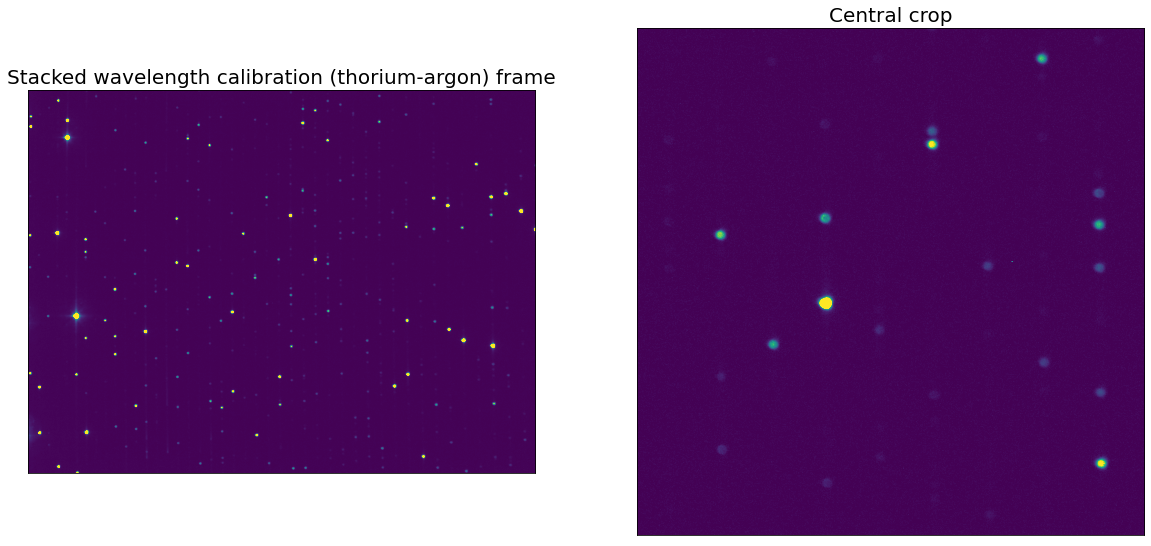

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

ax = axs[0]
ax.imshow(stacked_cal, vmin=0, vmax=600)
ax.set_title("Stacked wavelength calibration (thorium-argon) frame", size=20)

ax = axs[1]
ax.imshow(stacked_cal[1500:2500, 1500:2500], vmin=0, vmax=600)
ax.set_title("Central crop", size=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

And we do the same for the flat frames:

In [ ]:
flats = load_fits_images(base_dir=root_dir+obs_date+flat_dir)
print(f"{len(flats)} flat frames loaded")
calibrated_flats = calibrate(flats, masterdarks)
del flats
stacked_flat = stack_images(calibrated_flats)
del calibrated_flats

/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Flats//*[Ll]ight*.[Ff][Ii][Tt]*
['/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Flats/Flat_Light_0.100_secs_2022-03-21T23-13-22_001.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Flats/Flat_Light_0.100_secs_2022-03-21T23-13-25_002.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Flats/Flat_Light_0.100_secs_2022-03-21T23-13-27_003.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Flats/Flat_Light_0.100_secs_2022-03-21T23-13-30_004.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Flats/Flat_Light_0.100_secs_2022-03-21T23-13-33_005.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Flats/Flat_Light_0.100_secs_2022-03-21T23-13-36_006.fits', '/content/drive/My Drive/Colab Notebooks/ASTR3010_Lab/ObsData/2022-03-21/Flats/Flat_Light_0.100_secs_20

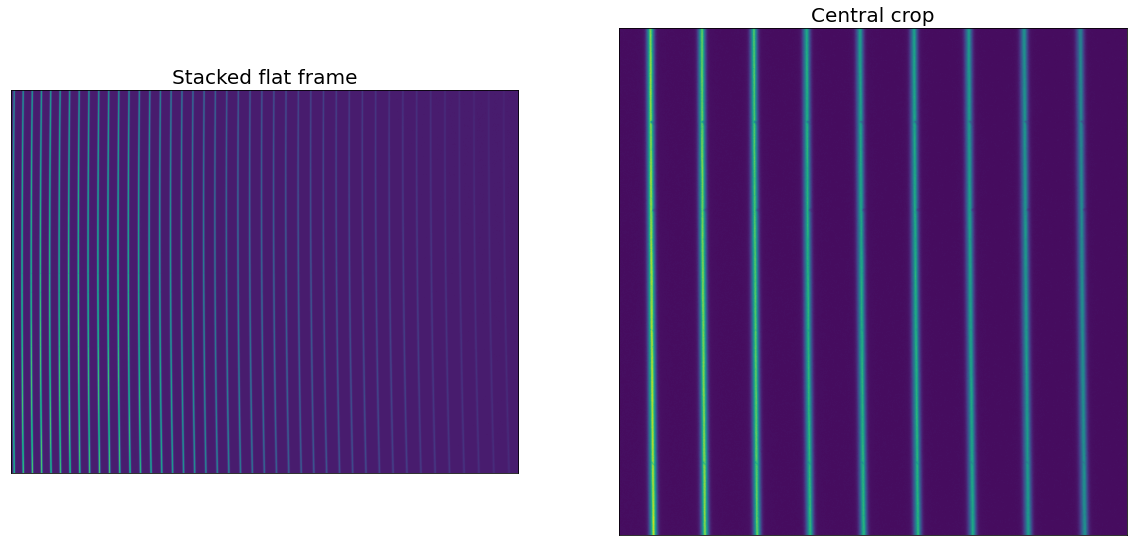

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

ax = axs[0]
ax.imshow(stacked_flat)
ax.set_title("Stacked flat frame", size=20)

ax = axs[1]
ax.imshow(stacked_flat[1500:2500, 1500:2500])
ax.set_title("Central crop", size=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

###Inspecting the Flat Lamp
We take flat frames as they give us a (roughly) evenly illuminated trace of each of the orders in the spectrograph. We use these to "trace" each order across the image, and finally use these traces to read out the pixel values for each order in our science frames. Below is a function that allows us to easily view the pixel values of a "slice" across the center of a given frame.

In [ ]:
def plot_slice(frame, slice_width=100):
    ny, nx = np.shape(frame)
    frame_slice = np.median(frame[int(ny / 2 - slice_width / 2): int(ny / 2 + slice_width / 2)], axis=0)
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.gca()
    
    ax.plot(frame_slice)
    ax.set_xlim(-.01*nx, 1.01*nx)
    ax.set_ylim(-.01*max(frame_slice), max(frame_slice))

So, let's take a look at a slice across the center of our flat frame, which will show a peak in brightness corresponding to each of the spectral orders:

(0.0, 6000.0)

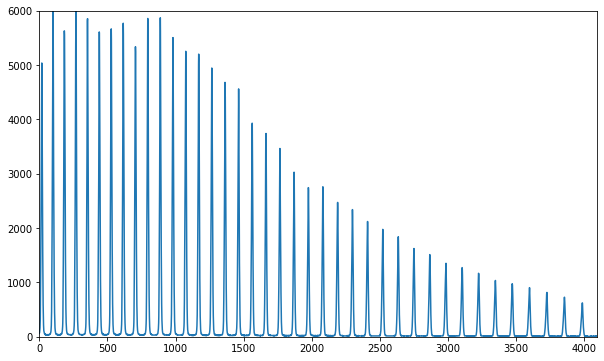

In [ ]:
plot_slice(stacked_flat)
plt.xlim(0, 4096)
plt.ylim(0, 6_000)

###Tracing the Orders Using the Flat Lamp
One of the key functions in extracting data from an echelle spectrograph frame is tracing the orders in a flat frame. This trace will be used to identify the pixels in our science frame where the light from the object lies. We generally can't use science objects themselves to do this, because they are usually too faint, have spectral features, etc. So the flat lamp gives us a 'clean' way to map where the light should be on the detector.

How would you trace the light along the orders? There are a few possibilities, but here we will take a slice as above, starting in the center of the frame, and head along the orders towards each edge. In each consectuive slice, we identify the peaks using the handy `find_peaks` function from the `scipy.signal` package. To make sure we are finding the 'right' peaks at each step and associating them with the correct order, we find each one individually, searching in only a small range around the last known peak coordinate in the x-axis (cross-dispersion direction). This way we can be sure that the peak we find is connected to the right one from the previous slice.

First, let's define the function that will find the peaks, and step through the various slices, storing the (x,y) peak locations of each order as a list.

In [ ]:
def trace_orders(frame, peakheight=10, peakprominence=5, peakdistance=25, peakwidth=(3, None),
                 width=20, slice_width=100, rowstep=50, debug_level=0):
    """
    A function to trace echelle orders in a flat spectrum frame. This takes a slice in cross-
    dispersion direction through the center of the frame, identifying the pixel location of the
    center of each order. From these locations, each order is traced independently to the edge
    of the frame in both directions.

    Args:
        frame (2d, array-like): The echelle frame in which to trace the orders
        peakheight (float, optional): The height of peaks as per scipy.signal.find_peaks,
        used to identify the order location in slices of the frame. Defaults to 10, may need
        fine-tuning.

        peakprominence (float, optional): Prominence. Defaults to 5.

        peakdistance (float, optional): [description]. Defaults to 25.

        peakwidth (tuple of floats, optional): [description]. Defaults to (3, None).

        width (int, optional): [description]. Defaults to 20.

        slice_width (int, optional): [description]. Defaults to 100.

        rowstep (int, optional): [description]. Defaults to 50.

        debug_level (int, optional): [description]. Defaults to 0.

    Returns:
        list of lists: a list of traces, each trace being a list of pixel locations in x and y
        of a single continuous order in the echelle frame.

    TO-DO:
        * Add the ability to have the frame in a different orientation -- automatically detect
        by seeing in which direction the mid-slice detects more evenly-spaced-ish peaks?

        * Automated detection of the best parameters for peak detection?
    """
    
    from scipy.signal import find_peaks
    
    ny, nx = np.shape(frame)

    traces = []
    
    mid_slice = np.median(frame[int(ny / 2 - slice_width / 2): int(ny / 2 + slice_width / 2)], axis=0)
    
    central_peak_locations = find_peaks(mid_slice,
                                        height=peakheight,
                                        prominence=peakprominence,
                                        distance=peakdistance,
                                        width=peakwidth)[0]

    for m, center_peak in enumerate(central_peak_locations):
        trace = []

        # Peak in the central row of pixels
        peak = center_peak
        r = int(ny / 2)
        trace.append([peak, r])

        # Step progressively through the rows to each edge of the frame
        negative_direction = np.arange(r, 0, -rowstep)
        positive_direction = np.arange(r, ny, rowstep)
        rows = np.concatenate((negative_direction, positive_direction))
        if debug_level > 0:
            print(rows)

        missed_peaks = 0
        for r in rows:
            
            # Reset to central peak when we reverse direction
            if r == int(ny / 2):
                peak = center_peak
                missed_peaks = 0
                
            if missed_peaks < 3:

                # Take a slice at our current row, of width specified by slice_width
                row = np.median(frame[int(r - slice_width / 2): int(r + slice_width / 2)], axis=0)

                # Consider only pixels in that slice local to the location of the previous peak
                localrow = row[max([0, int(peak - width / 2)]): min([int(peak + width / 2), nx])]

                _peaks = find_peaks(localrow,
                                    height=peakheight,
                                    prominence=peakprominence,
                                    distance=peakdistance,
                                    width=peakwidth)[0]

                if len(_peaks) == 1:
                    peak = _peaks[0] + max([0, peak - width / 2])
                    trace.append([peak, r])
                elif len(_peaks) > 1:
                    if debug_level > 0: print("More than one peak detected")
                    missed_peaks += 1
                else: 
                    if debug_level > 0: print(f"No peaks detected. Order {m}, pixel row {r}")
                    missed_peaks += 1
        
        # Make sure any traces are longer than at least a quarter of the detector,
        # and not just one or two peaks.
        # TK - do I need this step? If the order detection is working, it's not needed for sure.
        if len(trace) > ((ny / 4) / rowstep):
            traces.append(trace)
        
    return traces

Now we can call this function to trace the orders in our flat frame. There may be some inconsequential errors for orders that meet the edge of the frame. We may need to adjust the parameters to suit our particular flat frame.

In [ ]:
traces = trace_orders(stacked_flat, width=50, peakheight=100, peakprominence=5, rowstep=50)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


###Check peak-finding outputs
We can plot these traces to make sure everything worked well. We should see a set of near-parallel vertical lines.

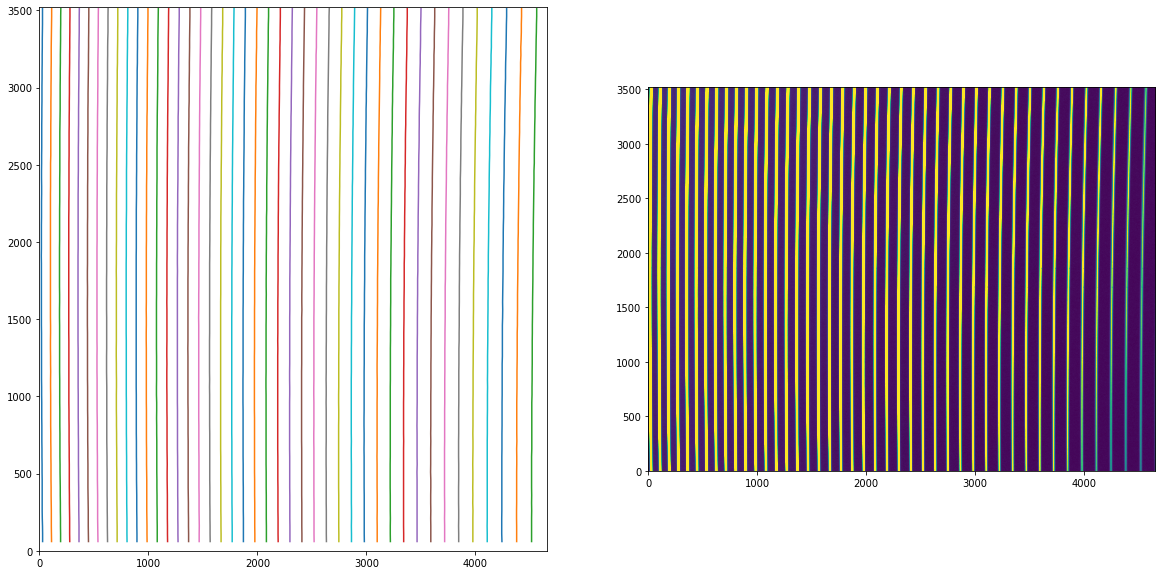

In [ ]:
ny, nx = np.shape(stacked_flat)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

for t in traces:
    x, y = np.transpose(t)
    sortkey = np.argsort(y)
    axs[0].plot(x[sortkey], y[sortkey])
axs[1].imshow(stacked_flat, vmin=0, vmax=400)

for ax in axs:
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)

If the traces look like they match the orders in the frame shown, the tracing was successful. If not, go back up to the cell where we generated the traces, and experiemnt with the `width`, `peakheight`, `peakprominence`, and `rowstep` parameters. `width` corresponds to the number of pixels side-to-side from the last peak location that will be searched for a new peak, `rowstep` tells the function how many pixels up or down to step. These two parameters should not need to be changed for any data from the Macquarie spectrograph.

`peakheight` and `peakprominence` may need to be adjusted if your flat spectrum is particularly bright or particularly dim. An exposure time of 3 seconds should give a well-exposed flat frame if using the small halogen lamp at the observatory. If a different exposure time, or a different lamp, was used then there may be issues with tracing with the default parameters.

### Fit a function to the peak trace

In order to be able to use these traces for extracting a spectrum, we want to interpolate between the discrete points at which we located the peaks above. To do this, we can fit a polynomial to the traces we've already generated. The orders are only slightly curved, so a low-order polynomial should do a good job of fitting them.

Here we define a function to try to fit each trace with an n-degree (default 2-degree) polynomial of x-position as a function of y-position (in spectrograph speak, cross-dispersion-direction position as a function of dispersion-direction position):

In [ ]:
def polynomials_from_traces(traces, deg=2):
    """
    """
    
    polynomials = []
    rms_residuals = []
    
    for t in traces:
        x, y = np.transpose(t)
        
        p = np.poly1d(np.polyfit(y, x, deg=deg))
        #rms_residuals.append(np.sqrt(np.mean((p(y) - x)**2)))
        
        polynomials.append(p)
        
    return polynomials

Now run the polynomial fit on the list of traces, with the solutions stored in the `polynomials` variable.

In [ ]:
polynomials = polynomials_from_traces(traces)

Finally, lets plot the polynomials in a 2D plot - this should mimic the plot of peaks generated above.

(0.0, 3520.0)

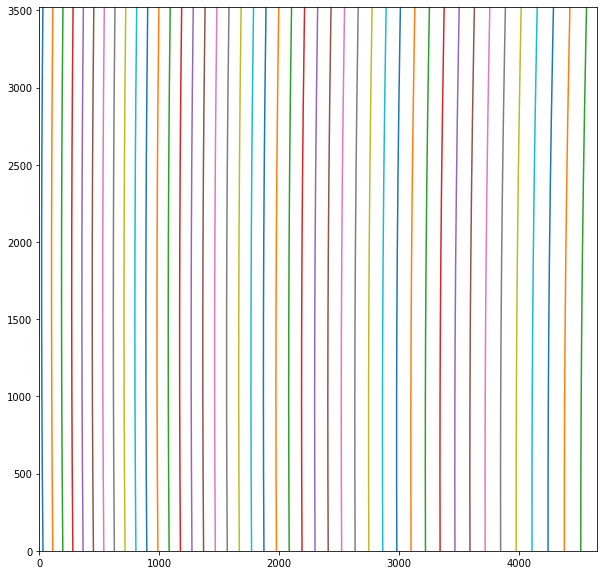

In [ ]:
ny, nx = np.shape(stacked_flat)

plt.figure(figsize=(10, 10))

disp = np.linspace(0, ny, ny)

for p in polynomials:
    xdisp = p(disp)
    plt.plot(xdisp, disp)
    
plt.xlim(0, nx)
plt.ylim(0, ny)

We now have a mapping of cross-dispersion-direction pixel position as a function of dispersion-direction pixel position for each order. This is enough to extract the spectrum from one of our science frames.

### Define the cross-dispersion profile

Now we have defined the peak of the light along each order, we can use that information to 'extract' the light from the CCD image, and generate the series of 1D spectra per order. There are a number of ways to perform this summation / intergation. The simplest is to define a box around the peak, and sum. However, if we know how the light is distributed, we can use this information to 'weight' the sum, so that pixels with more signal contribute more to the result than those with little signal. This optimises the resulting signal-to-noise ratio. The weighted sum is defined as:

$\large{F(\lambda)=\frac{\sum{w_i f_i}}{\sum{w_i}}}$

where $f_i$ is  the flux in the $i$'th pixel in the cross-dispersion direction, and $w_i$ is the $i$'th weight of that pixel.

A good approximation of the cross-dispersion profile of a multi-mode fibre is a Gaussian function. Here we fit a Gaussian to the cross-dispersion of each order.

In [ ]:
def slit_profile(frame, polynomial, width=50):
    """
    A function to read out an order's slit profile (cross-dispersion-direction intensity
    profile) for a given order (via polynomial to a generated trace) for optimal extraction
    of spectral information. The slit profile is used to apply differential weights to
    different pixels when reading out the intensity value at a given dispersion-direction
    pixel location.

    Args:
        frame (2D, array-like): A flat echelle frame, typically the same one that was used
        to trace orders and generate order location polynomials

        polynomial (callable function, np.poly1d): Polynomial as output from
        anarres.polynomials_from_traces()
        
        width (int, optional): The pixel width to inspect around each order center when
        building the slit function. This should be wide enough to fully contain the expected
        spread of light. Defaults to 30.

    Returns:
        list: A list containing the relative XD coordinate around the order center, and the
        meadian-combined intensity at that relative coordinate across the entire order.

    TO-DO:
        * Do we ever expect the slit function to vary much across a single order? Maybe yes,
        in terms of few-moded fibers, fibers used close to their single-mode cutoff, etc.?
    """
    
    ny, nx = np.shape(frame)
    
    disp = np.linspace(0, ny-1, ny)
    xdisp = polynomial(disp)
    
    slit_slices = []
    
    for d, xd in zip(disp, xdisp):
        if (xd - width / 2 > 0) & (xd + width / 2 < nx):
            slit_slice = frame[int(d)][int(xd - width / 2) + 1: int(xd + width / 2)]
            slit_slices.append(slit_slice)
    
    xd_relative = np.linspace(int(-width / 2), int(width / 2), width - 1)
    
    return [xd_relative, np.median(slit_slices, axis=0)]

In [ ]:
def define_slit_function(frame, polynomial):
    """
    An extension of anarres.slit_profile, where we also fit a Gaussian to the slit profile,
    generating a slit function that can be interpolated and gives sub-pixel accuracy

    Args:
        frame (2D, array-like): A flat echelle frame, typically the same one that was used
        to trace orders and generate order location polynomials

        polynomial (callable function, np.poly1d): Polynomial as output from
        anarres.polynomials_from_traces()

    Returns:
        function: A callable function giving the best-fit Gaussian for the read-out slit
        profile of the order.

    TO-DO:
        * Do we ever expect the slit function to vary much across a single order? Maybe yes,
        in terms of few-moded fibers, fibers used close to their single-mode cutoff, etc.?
    """
    
    from functools import partial
    from scipy.optimize import curve_fit
    
    # For our spectrograph at the moment, the fiber is not completely filled by the image of,
    # our star, so in the spectrograph the fiber cross-section looks like a Gaussian.
    # In the future, with a smaller fiber matched to the size of the `seeing` at the observatory,
    # this will look more like the cross section of the actual fiber core instead.
    def gaussian(x, A=1, sigma=3, mu=0, c=0):
        return A * 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2/(2 * sigma**2)) + c 

    x, y = slit_profile(frame, polynomial)

    # Normalise
    y_normed = y - min(y)
    y_normed = y_normed / max(y_normed)

    slit_vals = y_normed

    b = len(slit_vals)

    x = np.linspace(-b / 2, b / 2, b)

    fitparams, _ = curve_fit(gaussian, x, slit_vals)
    A, sigma, mu, c = fitparams

    #xfit = np.linspace(min(x), max(x), 200)
    #yfit = gaussian(xfit, *fitparams)

    #FWHM = sigma * np.sqrt(8 * np.log(2))
    
    return partial(gaussian, A=A, sigma=sigma, mu=mu, c=c)

Now plot the resulting profile for a given order.

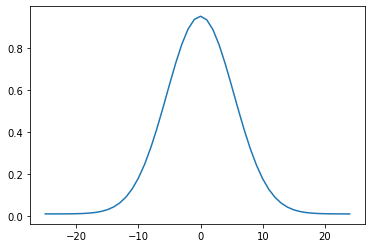

In [ ]:
slit = define_slit_function(stacked_flat, polynomials[30])

x = range(-25, 25)
plt.plot(x, slit(x))

### Extract the spectra
Now we have everything we need to extract each order of a frame into its own 1D spectrum, with a complete mapping of where the light falls on the detector. Note that we have established this mapping using the flat lamp calibration, and we are applying it directly to all the frames we wish to extract (science and arc-lamp frames, as well as the flats themselves).

The following functions use the trace information together with the slit profile weighting function to perform the extraction.

In [ ]:
def read_out_order(spectrum_frame, polynomial, flat_frame=None, read_width=50, debug_level=0):
    """
    A function to extract a single spectrograph order, using a polynomial fit to a trace previously
    calculated.

    Args:
        spectrum_frame (2D, array-like): The echelle frame from which to extract the order
        
        polynomial (callable function, np.poly1d): A callable function describing the order cross-
        dispersion coordinate as a function of dispersion coordinate.
        
        read_width (int, optional): [description]. Defaults to 30.
        
        debug_level (float, optional): The level of verbosity the function should print to the output
        for debugging or error-checking purposes. Higher number = more granularity of messages. 
        Defaults to 0, for no messages.

    Returns:
        1D, array-like, numpy.ndarray: The extracted order.

    TO-DO:
        * Incorporate a separately-generated slit function, so we can do a proper optimal-extraction
        * Keep an option for simple box extraction, maybe default to this if there is no slit function
        supplied
    """
    
    ny, nx = np.shape(spectrum_frame)
    
    if flat_frame is not None:
        slit_function = define_slit_function(flat_frame, polynomial)
    else:
        slit_function = None
    
    spectral_order = []
    ds = np.arange(0, ny, 1, dtype=int)
    xs = polynomial(ds)
    
    in_frame = (ds > 0) & (ds < ny) & (xs > 0) & (xs < nx)
    
    for d, x in zip(ds[in_frame], xs[in_frame]):
        
        # We extract using simple box extraction by default
        raw_values = np.array(spectrum_frame[int(d)][int(x) - read_width // 2: int(x) + read_width // 2], dtype="float64")
        if debug_level > 0: print(f"raw_values: {raw_values}")
        
        #window = np.linspace(int(-read_width / 2 - 1), int(read_width / 2), read_width)
        #slit = slit_function(window)

        if slit_function is not None: # We use our slit function to weight each pixel in the extraction
            if debug_level > 0: print("Weighting by slit function...")
            raw_values = raw_values * slit_function(np.linspace(int(x) - read_width//2 + x, int(x) + read_width//2 + x, len(raw_values), dtype="float64"))
            if debug_level > 0: print(f"raw_values * slit_function: {raw_values}")
        
        if len(raw_values) == read_width: # Why do I check for this? Orders right at the edge of the frame?
            out_value = np.sum(raw_values)
        else: out_value = np.nan
        
        spectral_order.append(out_value)
        
    if debug_level > 0: print(f"Order: {spectral_order}")
        
    return np.array(spectral_order)

Now we loop through each order, calling this function on each of our polynomial-fit traces. The resulting 1D spectrum is appended to the `sci_orders` list, which will contain all the extracted spectra.

In [ ]:
debug_level = 0
sci_orders = []

for i, p in enumerate(polynomials):
    if debug_level > 0: print(f"Polynomial {i}: {p}")
    if debug_level > 0: print("Reading out order with default settings...")
    order = read_out_order(stacked_light, p, stacked_flat, read_width=50)
    if debug_level > 0: print(f"Reading out order {i}: {order}")
    sci_orders.append(order)
    if debug_level > 0: print("---")

And now make a plot of all the orders stacked up.

(0.0, 2000.0)

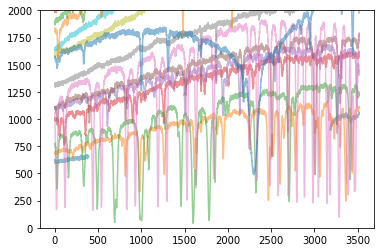

In [ ]:
for order in sci_orders:
    plt.plot(order, alpha=0.5)

# Change the y-axis limits to better see the extents of your data!
plt.ylim(0, 2000)

If only one single science frame (rather than a stack of multiple exposures) has been used, you may see many bright points above the 'continuum' curve of your actual orders. These are cosmic rays that hit the spectrograph detector during the exposure. They can be mitigated in the extraction software, or by median-combining several frames of the same target.

We will also extract the orders from our flat frame:

In [ ]:
debug_level = 0
flat_orders = []

for i, p in enumerate(polynomials):
    if debug_level > 0: print(f"Polynomial {i}: {p}")
    if debug_level > 0: print("Reading out order with default settings...")
    order = read_out_order(stacked_flat, p, stacked_flat, read_width=50)
    if debug_level > 0: print(f"Reading out order {i}: {order}")
    flat_orders.append(order)
    if debug_level > 0: print("---")

Let's plot them to  check they are OK. We should see a series of relatively smooth continuum spectra, perhaps just showing some small wiggles.

Recall that the 'flat' lamp is a continuum/black body source, so should be smooth and featureless. The overall shape of each order comes from the '**blaze function**' of the grating, which in turn is due to the shadowing of the echelle gratiing slices as we move away from the principal 'blaze' angle of the grating (where the light peaks).

The 'wiggles' are due to non-uniformity in the sensitivity of the detector pixels.

Both of these are 'multiplicative' effects, which act proportionally to the photons arriving at the detector. We can therefore use the fact that these spectra *should* be completely smooth and relatively flat within these narrow wavelength orders to correct all the data for these effects. We'll get to that later...

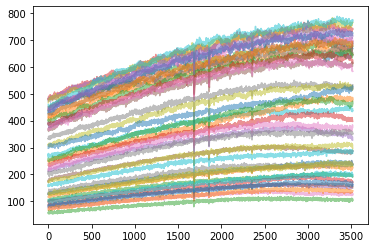

In [ ]:
for order in flat_orders:
    plt.plot(order, alpha=0.5)
# plt.ylim(0, 0)

Now extract our arc-lamp calibration frame:

In [ ]:
debug_level = 0
cal_orders = []

for i, p in enumerate(polynomials):
    if debug_level > 0: print(f"Polynomial {i}: {p}")
    if debug_level > 0: print("Reading out order with default settings...")
    order = read_out_order(stacked_cal, p, stacked_flat, read_width=50)
    if debug_level > 0: print(f"Reading out order {i}: {order}")
    cal_orders.append(order)
    if debug_level > 0: print("---")

Let's plot them to see how they look.

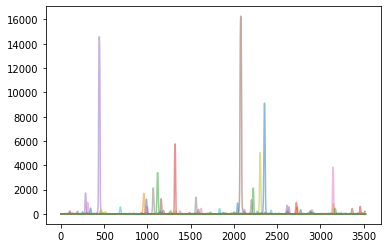

In [ ]:
for order in cal_orders:
    plt.plot(order, alpha=0.5)
# plt.ylim(0, 400)

Wavelength calibration orders show no spectral continuum, just emission lines of different brightness. The blaze function and pixel-to-pixel variations are still present, but they are much less obvious due to the nature of the light source.

### Explore your extracted data!

Now we can inspect individual orders, as a 1D array of values: pixel brightness as a function of dispersion-direction pixel position. Change the `order_index` variable until you find an order you like.

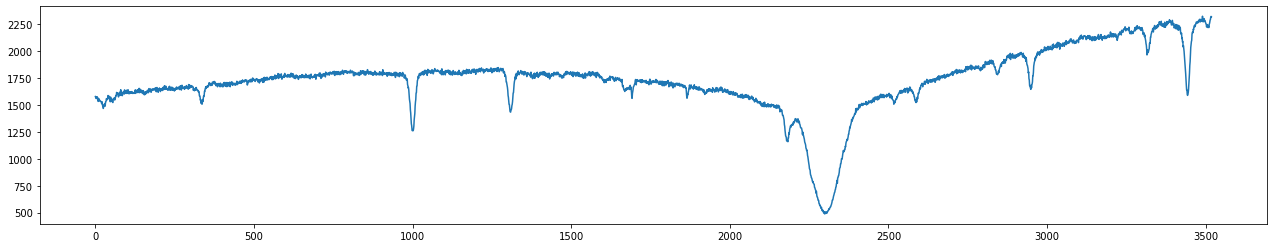

In [ ]:
order_index = 10

plt.figure(figsize=(22, 4))

plt.plot(sci_orders[order_index])
# plt.ylim(0, 10)

Again, one of the main things you notice when looking at a raw extracted echelle order is the distinctive curve, peaking at the center of the order, and dropping towards each edge. This is due to the efficiency of the diffraction grating in the spectrograph, and is called the "blaze function". An easy way to get rid of this is to divide our order by the corresponding order from our flat frame -- the flat spectrum should be (roughly) flat with wavelength, but still affected by the blaze function.


---
## Applying calibrations

In this section, we use our calibration frames to remove the instrument signature from our science spectra

### Getting Started: Different exposure types

First, let's look at the wavelength calibration and flat-lamp orders, as well as your chosen science order. 

***Your turn to code!***

Make a single plot with all three spectra shown. You will have to normalise them before you plot thme, so that they are all on the same scale. The first line is given to get you started.

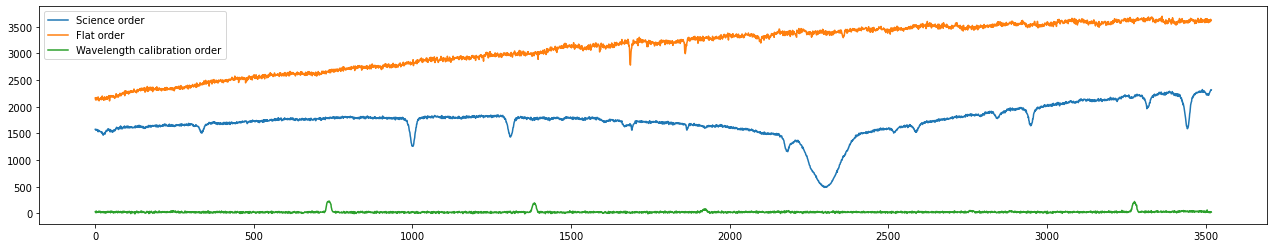

In [ ]:
order_index = 10

plt.figure(figsize=(22, 4))

plt.plot(sci_orders[order_index], label="Science order")
plt.plot(flat_orders[order_index] * 5, label="Flat order")
plt.plot(cal_orders[order_index] * 10, label="Wavelength calibration order")

plt.legend()

### Flat-fielding
All our orders will exhibit the same 'blaze function' curvature that arises from the diffraction grating, as well as the same variations due to pixel-to-pixel sensitivity differences of the detector. This is something we want to correct for. A simple way to do so is to divide our science and wavelength calibration orders by the corresponding flat-lamp order. This is called 'flat-fielding', by analogy with a similar multiplicative correction used in imaging data reduction.

***Your turn to code!***

Use the numpy function `np.divide' to apply the flat-field correction to the science order AND arc-lamp. Check the output by re-making the combined plot of your normalised frames, but now using your flat-field-corrected frames.

***Things to think about and record below:***
*   What do you notice about your data after flat-fielding?
*   Why does it not make sense to flat-field the flat-lamp?




In [ ]:
blaze_corrected_sci_orders = np.divide(sci_orders, flat_orders)
blaze_corrected_cal_orders = np.divide(cal_orders, flat_orders)

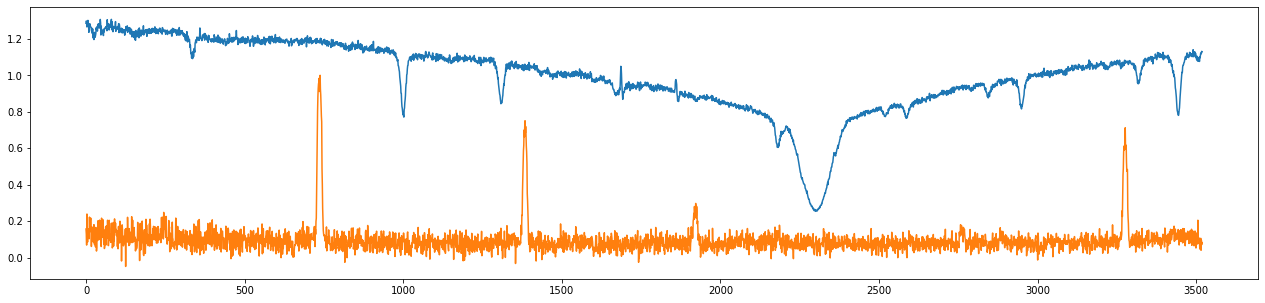

In [ ]:
plt.figure(figsize=(22, 5))

plt.plot(blaze_corrected_sci_orders[order_index] / np.mean(blaze_corrected_sci_orders[order_index]))
plt.plot(blaze_corrected_cal_orders[order_index] / np.max(blaze_corrected_cal_orders[order_index]))

# plt.ylim(0, 1)

### Save the flat-fielded spectra
If we want to save our spectra onto disk in order to use it in another notebook, we can use `numpy`'s `save()` function. You can use whatever filename you like, however incorporating the science target name, as well as the order index number is probably a good idea.

In [ ]:
order_index = 10
np.save("/content/drive/MyDrive/Colab Notebooks/ASTR3010_Lab/Sirius_halpha", blaze_corrected_sci_orders[order_index])
np.save("/content/drive/MyDrive/Colab Notebooks/ASTR3010_Lab/Sirius_calibration", blaze_corrected_cal_orders[order_index])

---

### Wavelength Calibration - Overview

The next important step in the reduction process is 'wavelength calibration'. This is where we re-map the flux from detector pixels to bins of constant wavelength step. To do this, we:
1.   Use the arc-lamp calibration frame.
1.   Compare the locations of the emission line peaks to their expected wavelengths from laboratory experiments.
1.   We then use this information to establish a 'dispersion function' that relates the detector pixel position to wavelength.
1.   Finally, we use this function to 'transform' the detector position coordinates into wavelength coordinates.

First, let's read the flat-fielded spectrum into a numpy array

In [ ]:
sci = np.load("/content/drive/MyDrive/Colab Notebooks/ASTR3010_Lab/Sirius_halpha.npy", allow_pickle=True)
wav = np.load("/content/drive/MyDrive/Colab Notebooks/ASTR3010_Lab/Sirius_calibration.npy", allow_pickle=True)

Quick plot to check things are as expected:

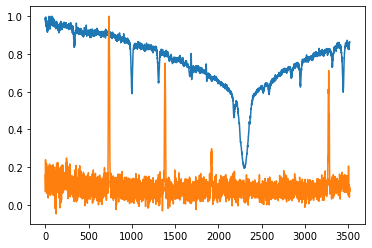

In [ ]:
plt.plot(sci / np.max(sci))
plt.plot(wav / np.max(wav))

### Wavelength Calibration: Step 1 - Find Peaks

Earlier, we used a handy `find_peaks` routine from the SciPy package to find the fibre trace. Use it again here to, well, find the peaks! This time, the peaks are in the wavelength direction. `find_peaks` returns an array containing the indices of the peak locations. There are a few important parameters to set: distance, prominence, height, and width. You can read more about find_peaks [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html).

***Your turn to code!***

*   Use `find_peaks` to locate the most prominent emission lines in your arc-lamp spectrum.
*   Check that the peaks make sense by plotting them on top of your arc lamp spectrum. For example, overplot a marker on the detected peaks.
*   Ideally you will find around a dozen or so peaks spread out across the order. Don't worry about the exact number just now - as long as you have more than a handful.
*   Advanced: `find_peaks` only returns the integer pixel location of the peak, and the true centre of the emission line will generally not lie in the centre of the pixel. How can you determine a more precise peak location, perhaps using the `find_peaks` output?


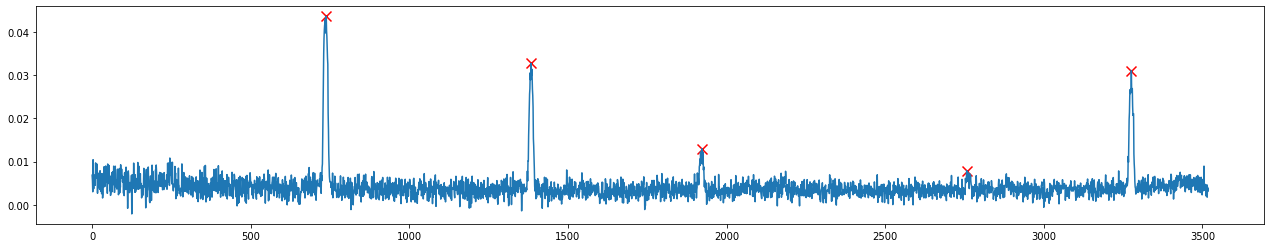

In [ ]:
# Here is some code and  comments to get you started

# Run find_peaks on the arc-lamp spectrum. This returns the indices of the peak pixels
peaks = find_peaks(wav, distance=100, prominence=0.008, height=0.005, width=7)

# Create a array to repesent the detector pixel position. This will be useful for plotting the found peaks
x = np.arange(len(wav))

# Plot the arc-lamp and over-plot the peak locations, e.g. marking the peak of the emission lines with a "x"
plt.figure(figsize=(22, 4))
plt.plot(x, wav, label="Thorium-Argon Lamp")

peaks_x = peaks[0]
peaks_y = peaks[1]["peak_heights"]

plt.scatter(peaks_x, peaks_y, color="r", marker="x", s=100)
  


### Wavelength Calibration: Step 2 - Select reference lines

You should have been given access to a reference list of Thorium (Th) and Argon (Ar) reference wavelengths. This list was generated using data from the [NIST](https://physics.nist.gov/PhysRefData/ASD/lines_form.html) website. The file is a comma separated value (csv) file with two columns: wavelength and transition strength. The latter can be used to distinguish which lines should be strongest in your observed spectrum.

Let's load the file, and have a look. You can play with the thresholds and wavelength ranges until you get something identifiably similar to your observed arc frame. For reference, the spectrograph provides roughly 0.02 $\unicode[serif]{xC5}$/pixel.


Maximum strength: 53000.0
Approximately a 29.4032 Angstrom span


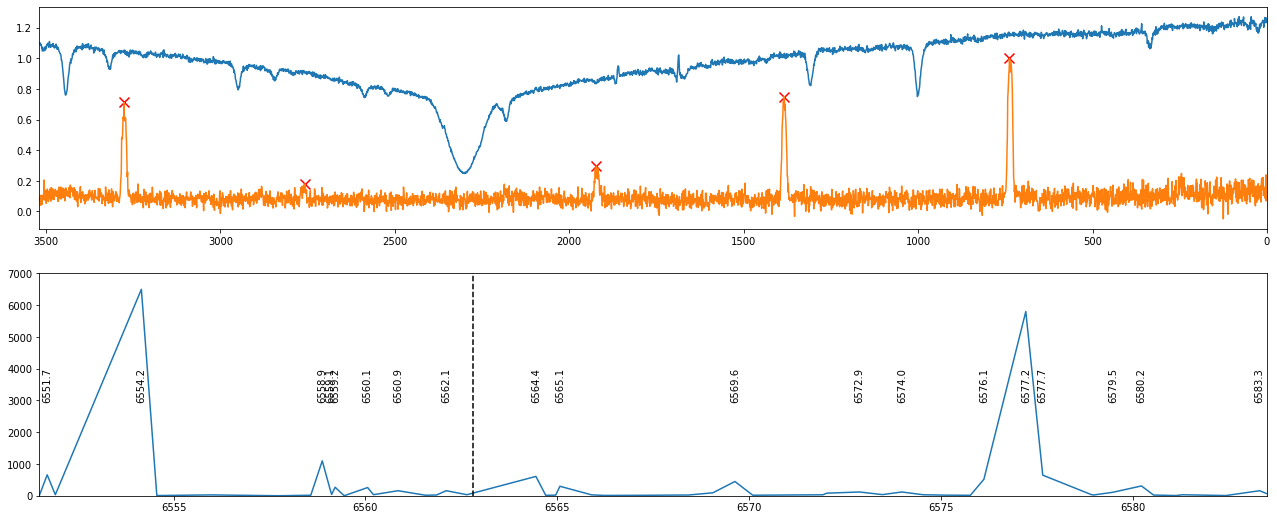

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(22, 9))

ax = axs[0]
ax.plot(sci / np.median(sci), label="Sirius")
ax.plot(wav / np.max(wav), label="Thorium-Argon Lamp")
ax.scatter(peaks_x, peaks_y / np.max(wav), color="r", marker="x", s=100)

# Flip the x-axis!
ax.set_xlim(len(sci), 0)

# Load the csv reference file
ThArRef = np.loadtxt(dir+"ThAr_air.csv", delimiter=',', skiprows=1)

# Here you can impose a threshold of lines to include based on their strength
print('Maximum strength:',np.max(ThArRef[:,1]))
flim = 0.
wref = ThArRef[ThArRef[:,1]>flim,0]  # Wavelength vector
fref = ThArRef[ThArRef[:,1]>flim,1]  # Strength vector

# Limit the approximate wavelength range
mask = np.where((wref>6530) & (wref < 6600))
wref = wref[mask]
fref = fref[mask]

ax = axs[1]
ax.plot(wref,fref)

ax.axvline(x=6562.81, ls="--", color="k")

# ax.set_xlim(6550, 6589)
minwl = 6551.5
print(f"Approximately a {(0.02 * (3.76 / 9) * len(sci))} Angstrom span")
maxwl = 6583.5

ax.set_xlim(minwl, maxwl)
ax.set_ylim(0, 7_000)

# Add wavelength labels
for x, y in zip(wref, fref):
  if x > ax.get_xlim()[0] and x < ax.get_xlim()[1]:
    if y > 100:
      ax.text(x, 0.5*ax.get_ylim()[1], f"{x:.1f}", rotation=90, ha="center", va="center")

In [ ]:
print(peaks[0])

[ 738 1384 1922 2757 3276]


### Wavelength Calibration: Step 3 - Fit a dispersion function

Now comes the tricky part of associating your list of peaks with the selected reference wavelengths. There are a few ways you can do this. One is to define a selection mask for the original lists, where you can include (=1) or exclude (=0) a given peak or wavelength, such that when you 'pair up' the selected elements, they are correctly identified. Below is an example of how you might do that, using an array of 1s and 0s, and the `np.where` function. If done well, your pairs of peaks and wavelengths should form a smooth correlation.

_Hint: It ia easier to start with a smaller number of brighter lines._[link text](https://)

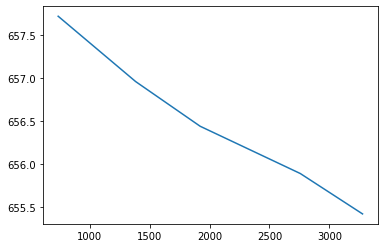

In [ ]:
wls = np.array([655.42, 655.89, 656.44, 656.96, 657.72])
pix = np.array([3276, 2757, 1922, 1384, 738])

plt.plot(pix, wls)

Now you have your (peak, wavelength) pairs, it's time to fit a function to those points. There are a few ways to do this, for example using `np.polyfit` together with `np.poly1d`; or `np.polynomial.Chebyshev`. Both of these options will let you define a function that can be called with the bestfit parameters and pixel positions, and return the wavelengths.

***Your turn to code!***
*   Fit some kind of polynomial to your peaks and wavelengths
*   Show that this is a good fit to your data. You may need to change your previous selections
*   Use this to define a function $P(x)$, that can be called to return the wavelengths of each pixel, such that $\lambda_i = P(x_i)$

Some hints are given below to get you started.


Text(0.5, 0, 'Pixel number')

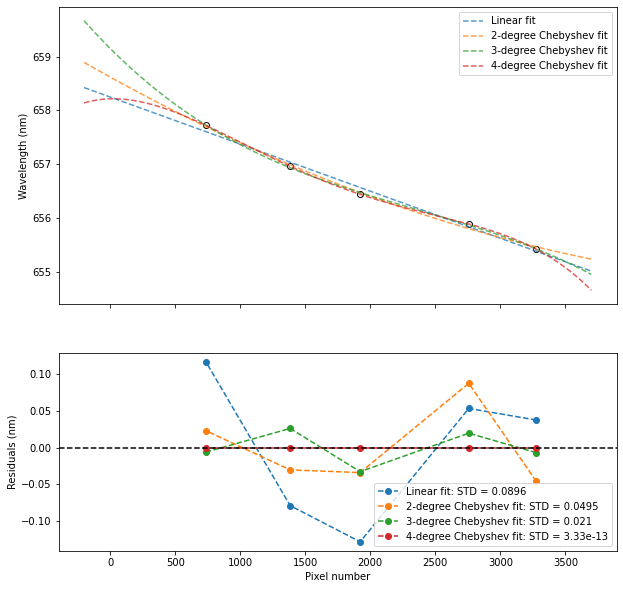

In [ ]:
wls = np.array([655.42, 655.89, 656.44, 656.96, 657.72])
pix = np.array([3276, 2757, 1922, 1384, 738])

fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={"height_ratios": [1.5, 1]})

axs[0].scatter(pix, wls, color="w", edgecolor="k")

p = np.poly1d(np.polyfit(pix, wls, deg=1))
pixfit = range(-200, 3700)
lin = axs[0].plot(pixfit, p(pixfit), ls="--", alpha=0.75, label="Linear fit")
axs[1].plot(pix, wls - p(pix), color=lin[0].get_color(), marker="o", ls="--", label=f"Linear fit: STD = {np.std(wls - p(pix)):.3g}")

for deg in [2, 3, 4]:
  p = np.polynomial.Chebyshev.fit(pix, wls, deg)
  cheb = axs[0].plot(pixfit, p(pixfit), ls="--", alpha=0.75, label=f"{deg:.0f}-degree Chebyshev fit")
  axs[1].plot(pix, wls - p(pix), color=cheb[0].get_color(), marker="o", ls="--", label=f"{deg:.0f}-degree Chebyshev fit: STD = {np.std(wls - p(pix)):.3g}")

axs[1].axhline(y=0, ls="--", color="k")

axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("Wavelength (nm)")
axs[1].set_ylabel("Residuals (nm)")
axs[1].set_xlabel("Pixel number")

Check the residuals of your fit.

***Your turn to code!***
*   Plot the difference between the reference wavelength and the wavelength predicted by your function at the corresponding peak position, as a function of wavelengths.
*   Evaluate the standard deviation of those residuals, remembering to provide units. You should aim to have a scatter of around 0.1-0.2 **pixels**.

In [ ]:
# Plot the difference of the reference and predicted wavelengths
# Include the standard deviation
# Include axes, units, etc.


In [ ]:
wavelength_mapping = np.polynomial.Chebyshev.fit(pix, wls, 3)
print(wavelength_mapping(0))
print(wavelength_mapping(len(sci)))

659.1539746478991
655.1700571924133


### Wavelength Calibration: Step 4 - Transform your data

Now you have a dispersion function, you can use this to transform the x-axis of your spectrum from pixels into constant steps in wavelength. How do you do that? 

***Your turn to code!***
*   Generate a vector of values that represent the detector locations, i.e. [0,1,2,...,npix-1]
*   Use your function to convert these into wavelength. Because your function is non-linear, this will give you a non-uniform wavelength step size, which is not so useful, so:
*   Generate a vector of regularly/linearly spaced wavelength locations that span the range of your data. To do that, you need to know the wavelength limits and step size you want
*   Interpolate your spectrum at these new linearly spaced locations
*   Do the same for your arc lamp spectrum
*   Make a plot showing your interpolated spectra, on a wavelength axis, and showing vertical lines at the reference wavelengths - these should go through the arc lamp peaks nicely

Some hints are given below.


Minimum Wavelength: 655.17 nanometers
Maximum Wavelength: 659.15 nanometers
Suggested pixel size: 0.0011 nanometers per pixel


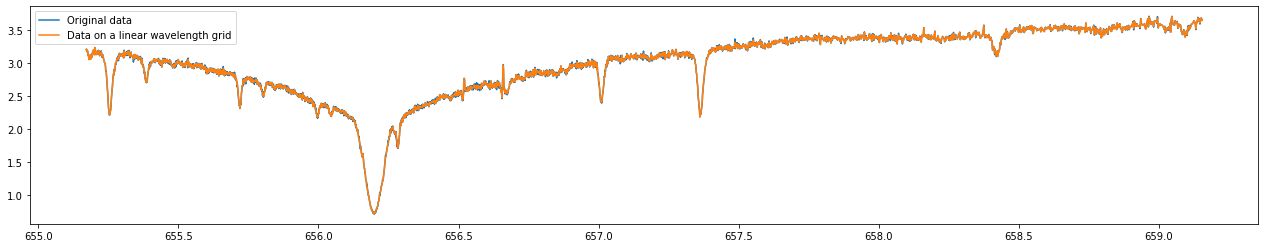

In [ ]:
npix = len(sci)      # Get the length of your order
xp = np.arange(0, npix)  # Generate the pixel positions

# Get the min/max wavelength, and compute the step size 'dw' that preserves the number of pixels
lmax = wavelength_mapping(0)
lmin = wavelength_mapping(npix)
dw = (lmax - lmin) / npix
print(f"Minimum Wavelength: {lmin:.2f} nanometers")
print(f"Maximum Wavelength: {lmax:.2f} nanometers")
print(f"Suggested pixel size: {dw:.4f} nanometers per pixel")


fig = plt.figure(figsize=(22, 4))
ax = fig.gca()

ax.plot(wavelength_mapping(xp), sci, label="Original data")

# Use this info to generate a linearly spaced wavelength axis
newlam = np.linspace(lmin, lmax, npix)

# Interpolate the observed spectra at the new wavelength pixel centres
newflux = np.interp(newlam, wavelength_mapping(xp[::-1]), sci[::-1])

# Plot the spectrum against wavelength. Repeat for the arc, and overplot the
# reference wavelengths using `vlines`
ax.plot(newlam, newflux, label="Data on a linear wavelength grid")

ax.legend()


### Save your calibrated spectrum

You have now completed the reduction of your data! Time to save the calibrated spectrum to disk, ready for analysis via another notebook.

***Your turn to code***

The most common data format in astronomy is fits, however it can be a little bulky for simple data. For simplicity, save your data instead as a two-column text file, comprising wavelength and flux.

In [ ]:
# Change the following to have the path and variables you want
np.savetxt("/content/drive/MyDrive/Colab Notebooks/ASTR3010_Lab/Sirius_calibrated.txt", np.c_[newlam, newflux])

### End of Data Reduction notebook

Please submit your completed notebook via iLearn